# Response Matrix Testing

In this notebook, I'm testing out the ability to construct a response matrix for MOXSI

In [85]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from sunpy.coordinates import Helioprojective, get_horizons_coord
from astropy.wcs.utils import pixel_to_pixel

from mocksipipeline.detector.response import SpectrogramChannel
from overlappy.wcs import overlappogram_fits_wcs, pcij_matrix

First, we are going to define a WCS for the 0th order and the 1st order

In [89]:
chan_0 = SpectrogramChannel(0, [])
chan_1 = SpectrogramChannel(1, [])
chan_3 = SpectrogramChannel(3, [])
chan_m1 = SpectrogramChannel(-1, [])
chan_m3 = SpectrogramChannel(-3, [])

In [90]:
observer = get_horizons_coord('SDO', '2020-11-09 18:00:00')
hpc_frame = Helioprojective(observer=observer, obstime=observer.obstime)

INFO: Obtained JPL HORIZONS location for Solar Dynamics Observatory (spac [sunpy.coordinates.ephemeris]


In [88]:
fov = (450,450)
ref_pix = ((fov[1]+1)/2, (fov[0]+1)/2, 1) * u.pix
pix_x = np.arange(fov[1]) #np.arange(775, 775+450, 1)#
pix_x_index = np.round(pix_x).astype(int)
pix_y = np.array(len(pix_x)*(fov[0]/2))

In [5]:
wcs_in = overlappogram_fits_wcs(
    fov,
    chan_0.wavelength,
    (chan_0.resolution[0], chan_0.resolution[1], chan_0.spectral_resolution),
    reference_pixel=ref_pix,
    reference_coord=(0*u.arcsec, 0*u.arcsec, chan_0.wavelength[0]),
    pc_matrix=pcij_matrix(-90*u.deg, 0*u.deg, order=chan_0.spectral_order, dispersion_axis=0),
    observer=observer,
)

In [46]:
mixing_matrices = []
for chan in [chan_0,]:# chan_1, chan_3, chan_m1, chan_m3]:
    print('spectral order = ',chan.spectral_order)
    wcs_out = overlappogram_fits_wcs(
        chan.detector_shape,
        chan.wavelength,
        (chan.resolution[0], chan.resolution[1], chan.spectral_resolution),
        reference_pixel=chan.reference_pixel,
        reference_coord=(0*u.arcsec, 0*u.arcsec, chan.wavelength[0]),
        pc_matrix=pcij_matrix(-90*u.deg, 0*u.deg, order=chan.spectral_order, dispersion_axis=0),
        observer=observer,
    )
    mixing_matrix = np.zeros((pix_x.shape[0], chan_0.detector_shape[1]))
    for iz in range(10):
        pix_z = np.array(len(pix_x)*[iz])
        pix_det,_,_ = pixel_to_pixel(wcs_in, wcs_out, pix_x, pix_y, pix_z)
        pix_det_index = np.round(pix_det).astype(int)
        in_bounds = np.logical_and(pix_det_index < mixing_matrix.shape[1],
                                   pix_det_index >= 0)
        mixing_matrix[pix_x_index[in_bounds], pix_det_index[in_bounds]] = 1
    mixing_matrices.append(mixing_matrix.copy())

spectral order =  0


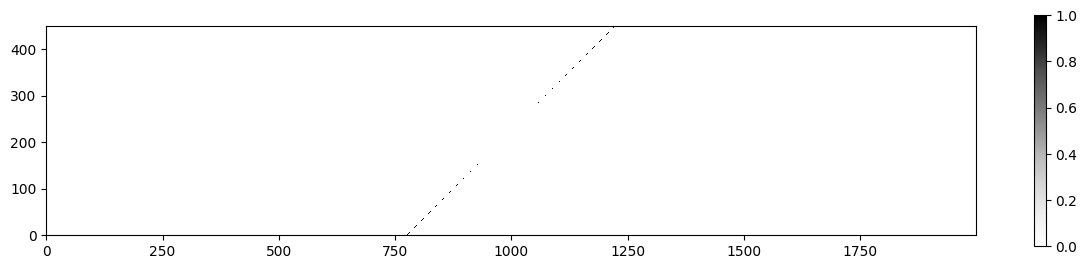

In [48]:
for m in mixing_matrices:
    plt.figure(figsize=(15,3))
    plt.imshow(m,  cmap='Greys',origin='lower', interpolation='none')
    plt.colorbar()
    #plt.xlim(775,1225)

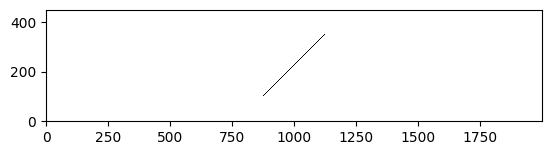

In [49]:
plt.imshow(mixing_matrix,#[:,775:1225],
           interpolation='none', origin='lower', cmap='Greys')